## 0 Set Up

### 0.1 Environment Set Up

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0.2 Create Data Importation Function

By observing the columns of each table, I would like to extract several statistical measurements(mean, median, max, and min) of the features. Below is the function to quickly form the data we want. To clarify, features will create as follow:
* Create min, max, mean of temperature
* Create min, max, mean of monthly precipitation (nm)
* Create min, max, mean of monthly soil moisture
* Create mean of monthly NVDI 
* Season

In [ ]:
# define a function to transform data structure
def transformation(filepath, col_name):
  '''
  Calculate the mean, median, min, and max value of the measurement.
  Return a semi-long table
  '''
  # read data
  data = pd.read_csv(filepath, parse_dates=['end_date'], usecols=['end_date', 'region_id', col_name])
  data['end_date'] = data['end_date'].dt.date.astype('datetime64')
  data = data.astype({'region_id':'category'})

  # check missing values
  print(data.isnull().sum(), '\n')

  # calculate different measurements of the feature
  data_long = data.pivot(index='end_date', columns='region_id', values=col_name).resample('M').agg(['min', 'max', np.mean, np.median]).reset_index().melt(id_vars=['end_date'])
  data_long.columns = data_long.columns.fillna('measured')

  # convert to semi-wide dataframe
  data_wide = data_long.pivot(index = ['end_date', 'region_id'], columns = 'measured', values = 'value').reset_index()
  data_wide = data_wide.rename(columns={'max':'max_'+col_name, 'mean':'mean_'+col_name, 'median':'median_'+col_name, 'min':'min_'+col_name})
  data_wide.columns.name = None
  data_wide = data_wide.astype({'region_id':'category'})
  return data_wide

### 0.3 Create Plotting Function

Also, I would like to plot the distribution of data quickly.

In [ ]:
def plot_diy(data, x=None, y=None, xlabel=None, ylabel=None, hue=None, figsize=None):
  '''
  Plot the distribution of the value on one plot
  '''
  _ = plt.figure(figsize= (10, 8))
  _ = sns.lineplot(x=x, y=y, hue=hue, data=data)
  _ = plt.xlabel(xlabel=xlabel)
  _ = plt.ylabel(ylabel=ylabel)
  plt.show()

In [ ]:
def facet_histplot(data, col, x, col_wrap=5, binwidth=2):
  '''
  Plot the histogram of the value separately
  '''
  g = sns.FacetGrid(data, col=col, col_wrap=col_wrap)
  g.map(sns.histplot, x, binwidth=binwidth)
  plt.show()

## 1 Data Importing and Cleaning

### 1.1 Import Production Quantity Data

In [ ]:
production = pd.read_csv("/content/drive/MyDrive/gro/Production Quantity.csv", parse_dates=['end_date'], usecols=['end_date', 'prod', 'region_id'])

In [ ]:
# check if there are missing values
production.isnull().sum()

end_date     0
prod         0
region_id    0
dtype: int64

In [ ]:
production['end_date'] = production['end_date'].dt.date.astype('datetime64')
prod = production.astype({'region_id':'category'})

In [ ]:
prod.head()

,end_date,prod,region_id
0,2015-01-31,171725,93
1,2015-02-28,188325,93
2,2015-03-31,247856,93
3,2015-04-30,282791,93
4,2015-05-31,291057,93


As we can see, the production quantity of Grople syrup in each region varies from one to another, while they all folow a certain seasonal trend that reaches paek at the Fall of each year, and get to the bottom at the Spring of the next year.

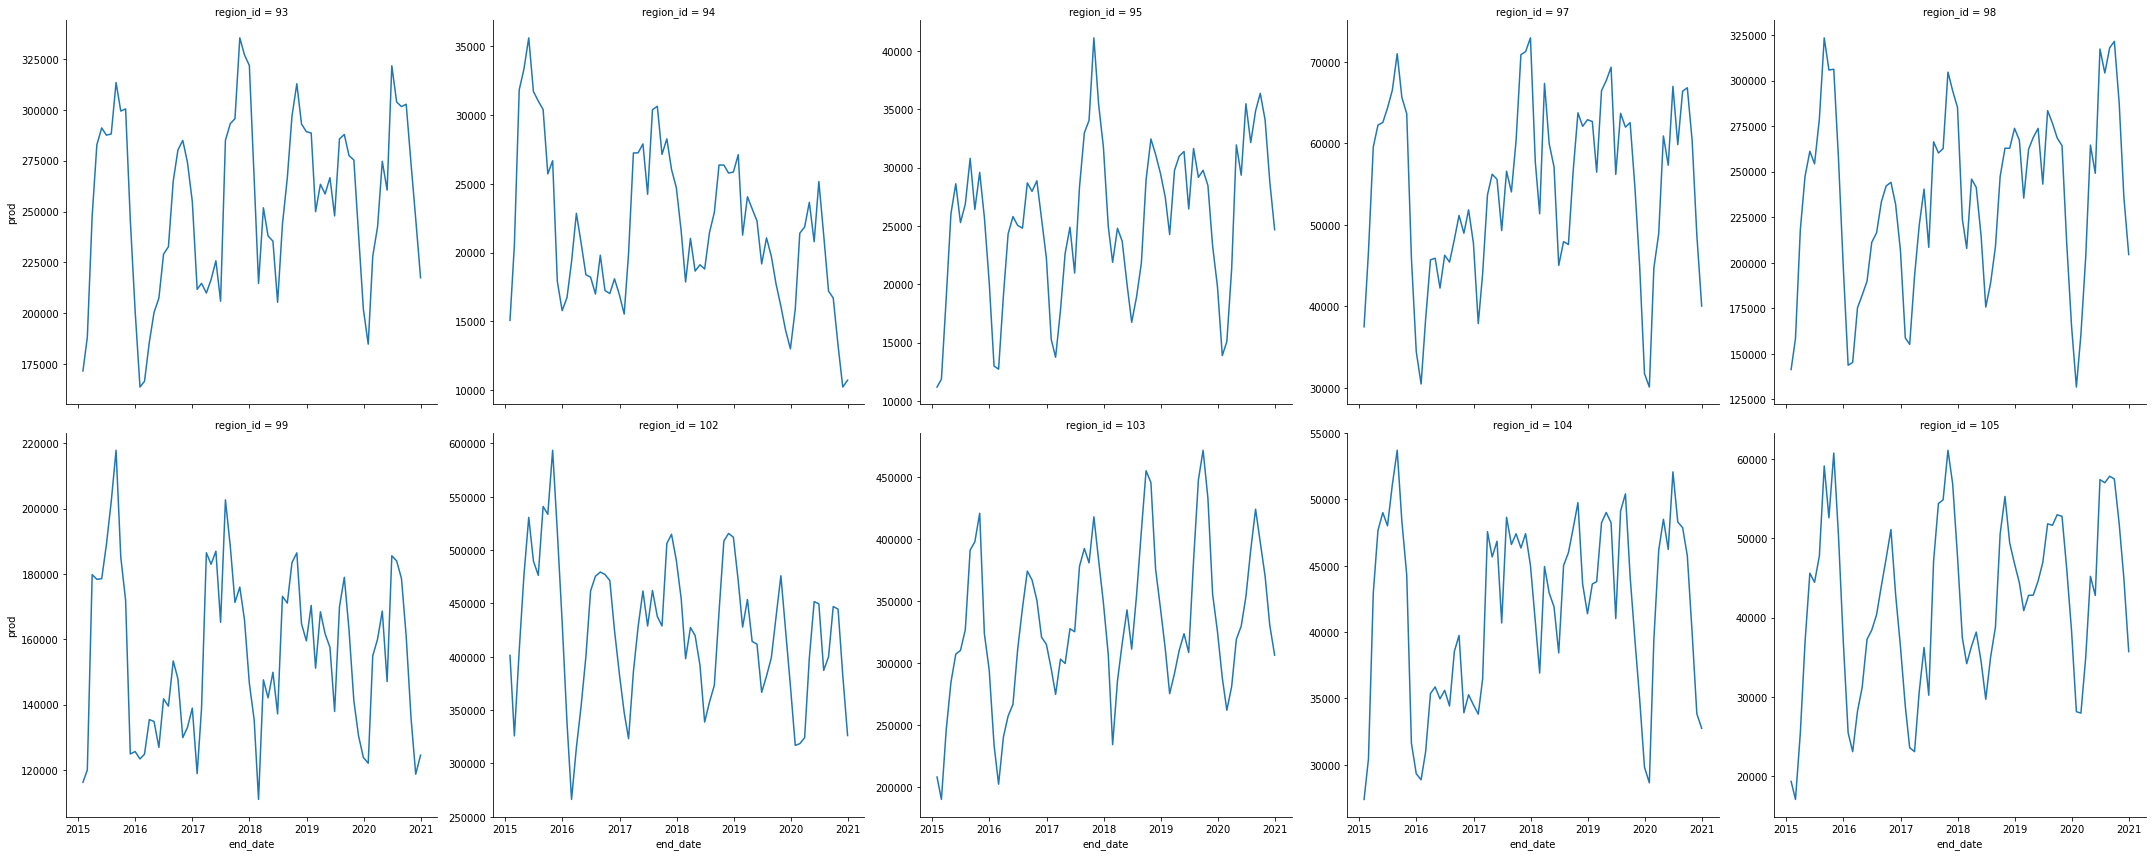

In [ ]:
prod_wide = prod.pivot(index='end_date', columns='region_id', values='prod').reset_index()
g = sns.FacetGrid(prod, col='region_id', col_wrap=5, sharey=False, height=6)
g.map(sns.lineplot, 'end_date', 'prod')
plt.show()

#### 1.1.1 Seasonal Analysis

By using ACF to plot the seasonality, we can clearly see that during June, July, and August, the production quantity is much higher than the rest of the time; While the production in January, Feburary, and March are much lower in the whole year.

In [ ]:
from statsmodels.graphics import tsaplots
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def seasonal_plot(func='acf', lags=24):
  fig, axs = plt.subplots(2, 5, figsize=(30, 12))
  plt.subplots_adjust(hspace=0.3)
  fig.suptitle("Production Quantity {}".format(func.upper()), fontsize=18, y=0.95)
  regions = prod['region_id'].unique().tolist()

  # loop through tickers and axes
  for region, ax in zip(regions, axs.ravel()):
      # filter prod for region and plot on specified axes
      data = prod[prod['region_id'] == region].set_index('end_date').drop('region_id', axis=1)
      if func == 'acf':
        tsaplots.plot_acf(data['prod'], lags=lags, ax=ax)
      elif func == 'pacf':
        tsaplots.plot_pacf(data['prod'], lags=lags, ax=ax)
      else:
        break

      # chart formatting
      ax.set_title('Region_{}'.format(region))
      ax.set_xlabel("Date")

plt.show()

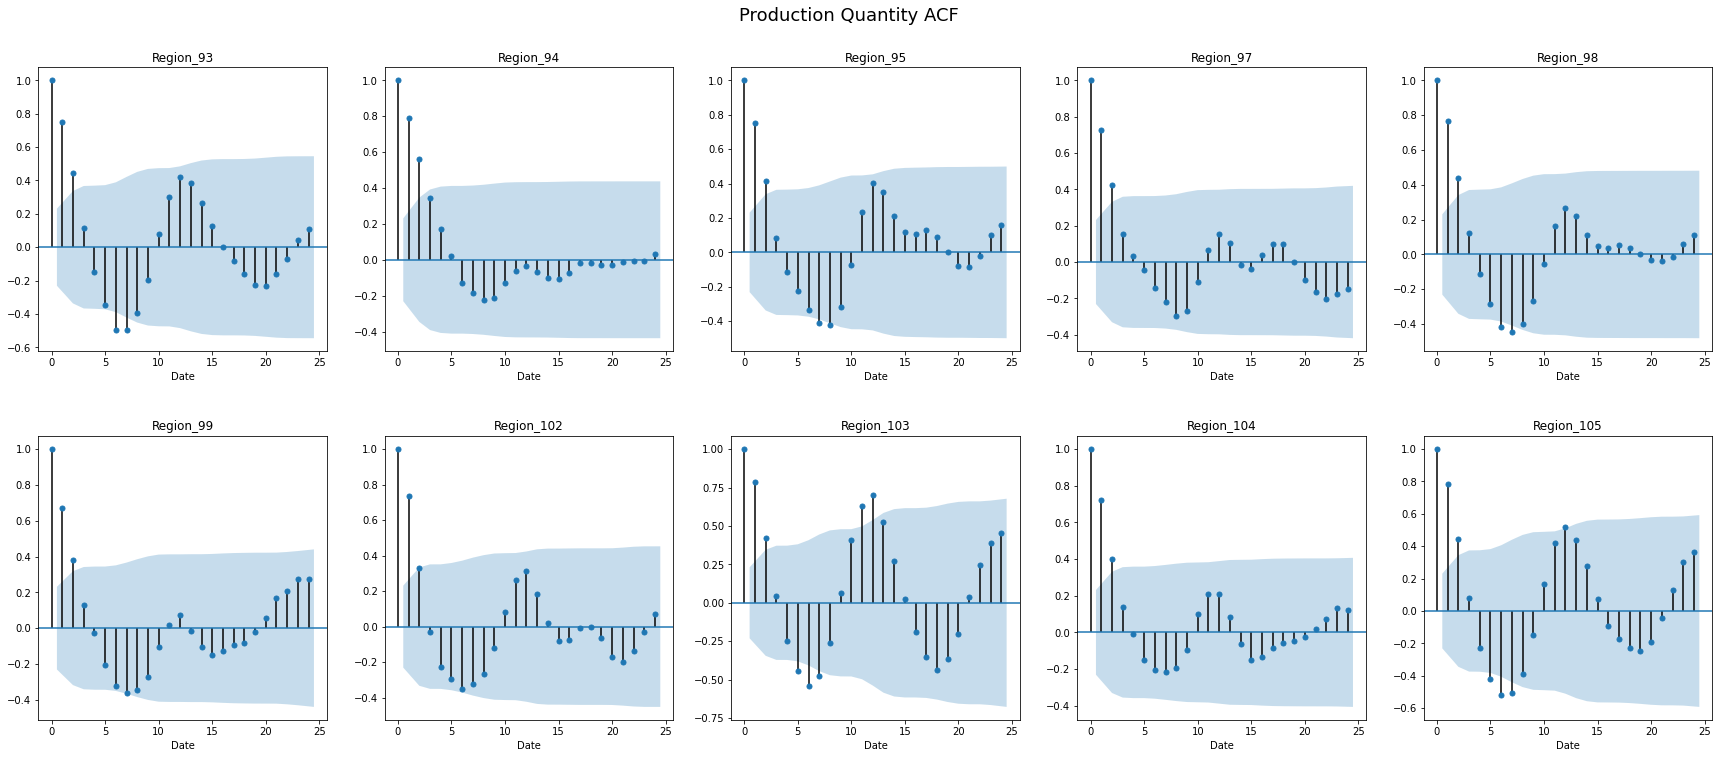

In [ ]:
seasonal_plot('acf')

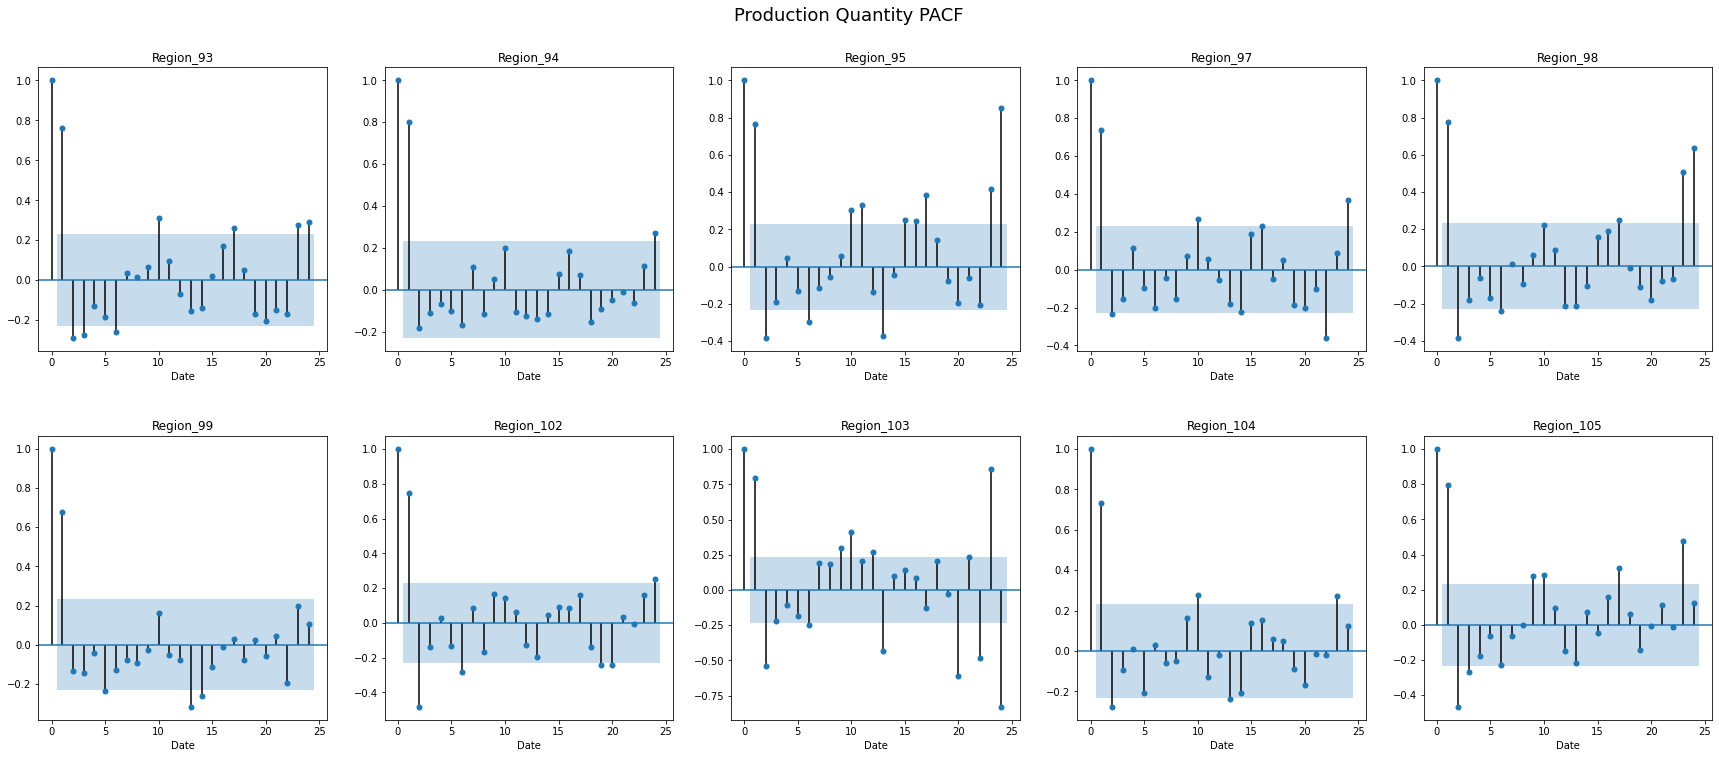

In [ ]:
seasonal_plot('pacf')

### 1.2 Import Daily Precipitation Data

By inspecting the distribution of precipitation in each region, we can see that it's slightly right skewed with some regions contain outliers (such as region 95, 98, and 105). However, considering that plants are sensitive to precipitation and the range, I would like to calculate other statistical measurements as predictors.

In [ ]:
precip = transformation('/content/drive/MyDrive/gro/Daily Precipitation.csv', 'precip')
precip.head()

end_date     0
precip       0
region_id    0
dtype: int64 



,end_date,region_id,max_precip,mean_precip,median_precip,min_precip
0,2014-01-31,93,32.823651,2.541758,0.143766,0.000375
1,2014-01-31,94,12.854196,0.903706,0.037263,0.000000
2,2014-01-31,95,37.847717,2.754678,0.119823,0.000716
3,2014-01-31,97,12.882543,1.486648,0.100079,0.000000
4,2014-01-31,98,91.762702,4.303181,0.241339,0.002284


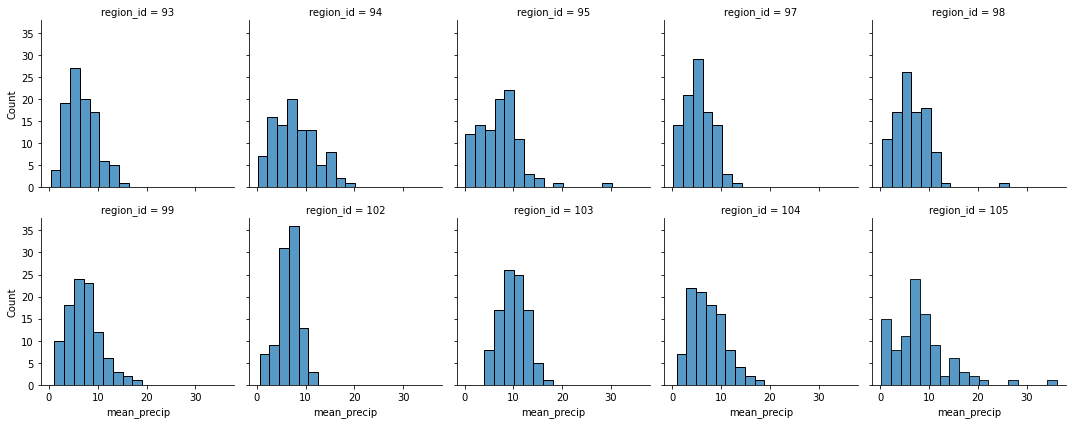

In [ ]:
facet_histplot(precip, col='region_id', x='mean_precip')

### 1.3 Import Daily Temperature Data

We also do the same for daily temperature, and we can see there are no outliers throughout all regions. Temperatures are statistically stable in each region.

In [ ]:
temp = transformation('/content/drive/MyDrive/gro/Daily Temperature.csv', 'temp')
temp.head()

end_date     0
temp         0
region_id    0
dtype: int64 



,end_date,region_id,max_temp,mean_temp,median_temp,min_temp
0,2014-01-31,93,30.196658,25.482158,24.551844,23.653173
1,2014-01-31,94,29.822020,25.857623,26.083082,21.543629
2,2014-01-31,95,26.503133,22.430714,22.277142,17.598677
3,2014-01-31,97,28.656484,25.554444,25.789143,21.163349
4,2014-01-31,98,26.682990,23.789993,23.040837,21.814284


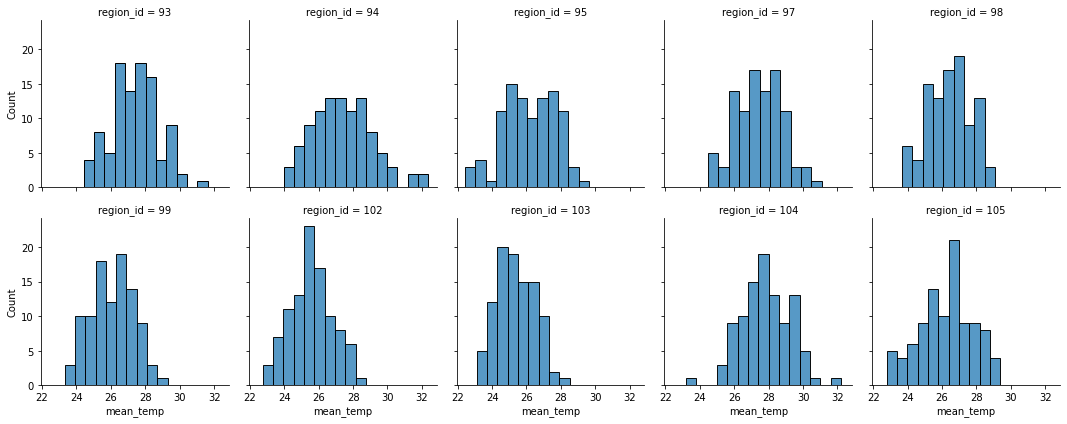

In [ ]:
facet_histplot(temp, col='region_id', x='mean_temp', binwidth=0.6)

### 1.4 Import Daily Soil Mositure Data

In [ ]:
smos = transformation('/content/drive/MyDrive/gro/Daily Soil Mositure.csv', 'smos')
smos.head()

end_date     0
smos         0
region_id    0
dtype: int64 



,end_date,region_id,max_smos,mean_smos,median_smos,min_smos
0,2014-01-31,93,0.449157,0.287870,0.288422,0.180879
1,2014-01-31,94,0.544213,0.285901,0.265524,0.173545
2,2014-01-31,95,0.390691,0.268944,0.266812,0.141523
3,2014-01-31,97,0.389048,0.295487,0.309190,0.212361
4,2014-01-31,98,0.281770,0.207876,0.217891,0.138269


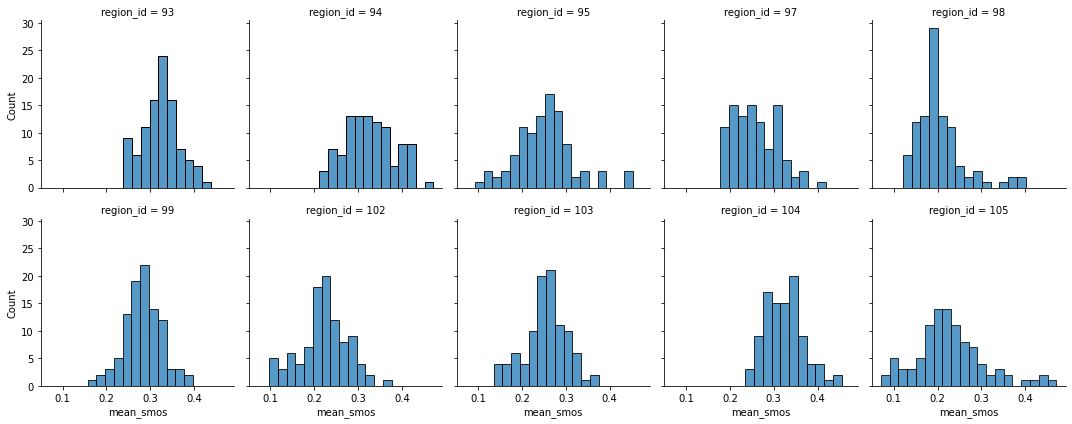

In [ ]:
facet_histplot(smos, col='region_id', x='mean_smos', binwidth=0.02)

### 1.5 Import Eight Day NDVI Data

Since the NDVI is measured by a span of 8 days, I would like to just claculate the monthly average NDVI for each region as the range of NDVI in each month does not vary greatly. According to regerences of NDVI, NDVI with higher than 0.6 is considered dense and good for the growth of plants. While we can see that every region's NDVI is above 0.6 and range between 0.7 and 0.85.

In [ ]:
ndvi = pd.read_csv('/content/drive/MyDrive/gro/Eight Day NDVI.csv', parse_dates=['end_date'], usecols=['end_date', 'ndvi', 'region_id'])
ndvi['end_date'] = ndvi['end_date'].dt.date.astype('datetime64')
ndvi = ndvi.astype({'region_id':'category'})

In [ ]:
ndvi.isnull().sum()

end_date     0
ndvi         0
region_id    0
dtype: int64

In [ ]:
ndvi_long = ndvi.pivot(index='end_date', columns='region_id', values='ndvi').resample('D').interpolate().bfill()\
           .resample('M').mean().reset_index().melt(id_vars=['end_date'], value_name='ndvi')
ndvi_long = ndvi_long.sort_values(['end_date', 'region_id'], ignore_index=True)
ndvi_long = ndvi_long.astype({'region_id':'category'})
print(ndvi_long.isnull().sum(), '\n')
print(ndvi_long.dtypes, '\n')
ndvi_long.head()

end_date     0
region_id    0
ndvi         0
dtype: int64 

end_date     datetime64[ns]
region_id          category
ndvi                float64
dtype: object 



,end_date,region_id,ndvi
0,2014-01-31,93,0.731934
1,2014-01-31,94,0.767263
2,2014-01-31,95,0.726038
3,2014-01-31,97,0.757521
4,2014-01-31,98,0.793151


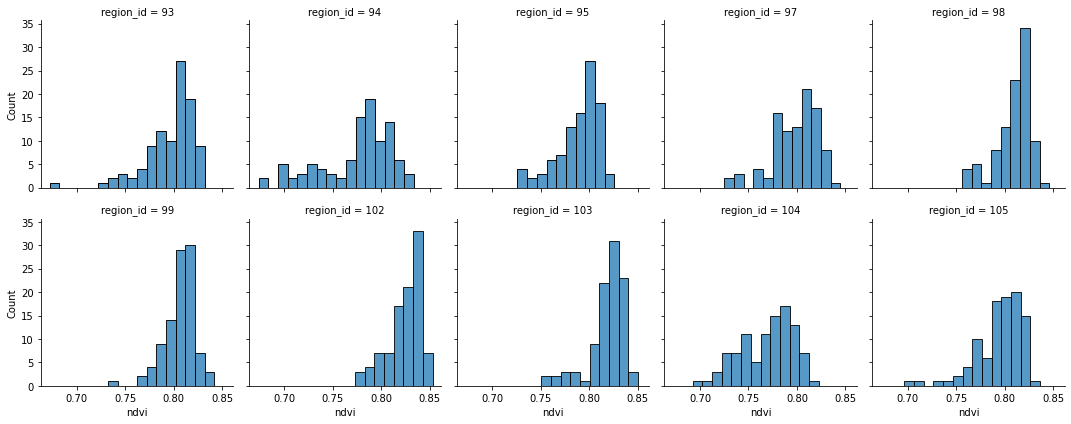

In [ ]:
facet_histplot(ndvi_long, col='region_id', x='ndvi', binwidth=0.01)

### 1.6 Combine all tables

In [ ]:
df = prod.merge(precip, on=['end_date', 'region_id'])\
         .merge(temp, on=['end_date', 'region_id'])\
         .merge(smos, on=['end_date', 'region_id'])\
         .merge(ndvi_long, on=['end_date', 'region_id'])
# add season
df['season'] = df['end_date'].dt.month % 12 // 3 + 1
# add a seasonal feature
df['harvest'] = np.empty(len(df))
df.loc[(df['end_date'].dt.month >= 6) & (df['end_date'].dt.month <= 8), 'harvest'] = 'harvested'
df.loc[df['end_date'].dt.month <= 3, 'harvest'] = 'growing'
df.loc[(df['harvest'] != 'harvested' ) & (df['harvest'] != 'growing'), 'harvest'] = 'normal'
df = df.astype({'harvest': 'category', 'season':'category'})

In [ ]:
print(df.dtypes, '\n')
df.head()

end_date         datetime64[ns]
prod                      int64
region_id              category
max_precip              float64
mean_precip             float64
median_precip           float64
min_precip              float64
max_temp                float64
mean_temp               float64
median_temp             float64
min_temp                float64
max_smos                float64
mean_smos               float64
median_smos             float64
min_smos                float64
ndvi                    float64
season                 category
harvest                category
dtype: object 



,end_date,prod,region_id,max_precip,mean_precip,median_precip,min_precip,max_temp,mean_temp,median_temp,min_temp,max_smos,mean_smos,median_smos,min_smos,ndvi,season,harvest
0,2015-01-31,171725,93,54.497266,4.394452,0.260547,0.001112,27.547240,25.003593,25.409946,21.700680,0.515493,0.318552,0.314466,0.192748,0.755442,1,growing
1,2015-02-28,188325,93,15.357199,1.206137,0.150836,0.000517,30.535201,26.807568,27.113245,21.461607,0.401876,0.291452,0.281567,0.180339,0.765396,1,growing
2,2015-03-31,247856,93,13.704099,3.454652,1.636423,0.089132,30.910728,26.954109,26.951388,22.091759,0.331012,0.251969,0.257343,0.180339,0.742858,2,growing
3,2015-04-30,282791,93,35.989889,10.466472,9.357805,0.201866,29.560593,26.948865,27.299628,24.085684,0.319016,0.248915,0.248753,0.174857,0.785234,2,normal
4,2015-05-31,291057,93,29.155820,9.007986,7.340673,1.775833,29.758767,25.405121,25.712135,20.800400,0.401614,0.280602,0.261209,0.197073,0.803802,2,normal


In [ ]:
df.to_csv('/content/drive/MyDrive/gro/combined_data.csv')

## 2 Data Visualization

### 2.1 Mean Precipitation vs Production

Except *region 103*, all other regions' precipitation is positive associated with production quantity, with some regions with sligh associations.  Also, the distribution of production quantity varies in different regions, region 93, 98, 102,  and 103 have wider distribution while others are more concentrated.

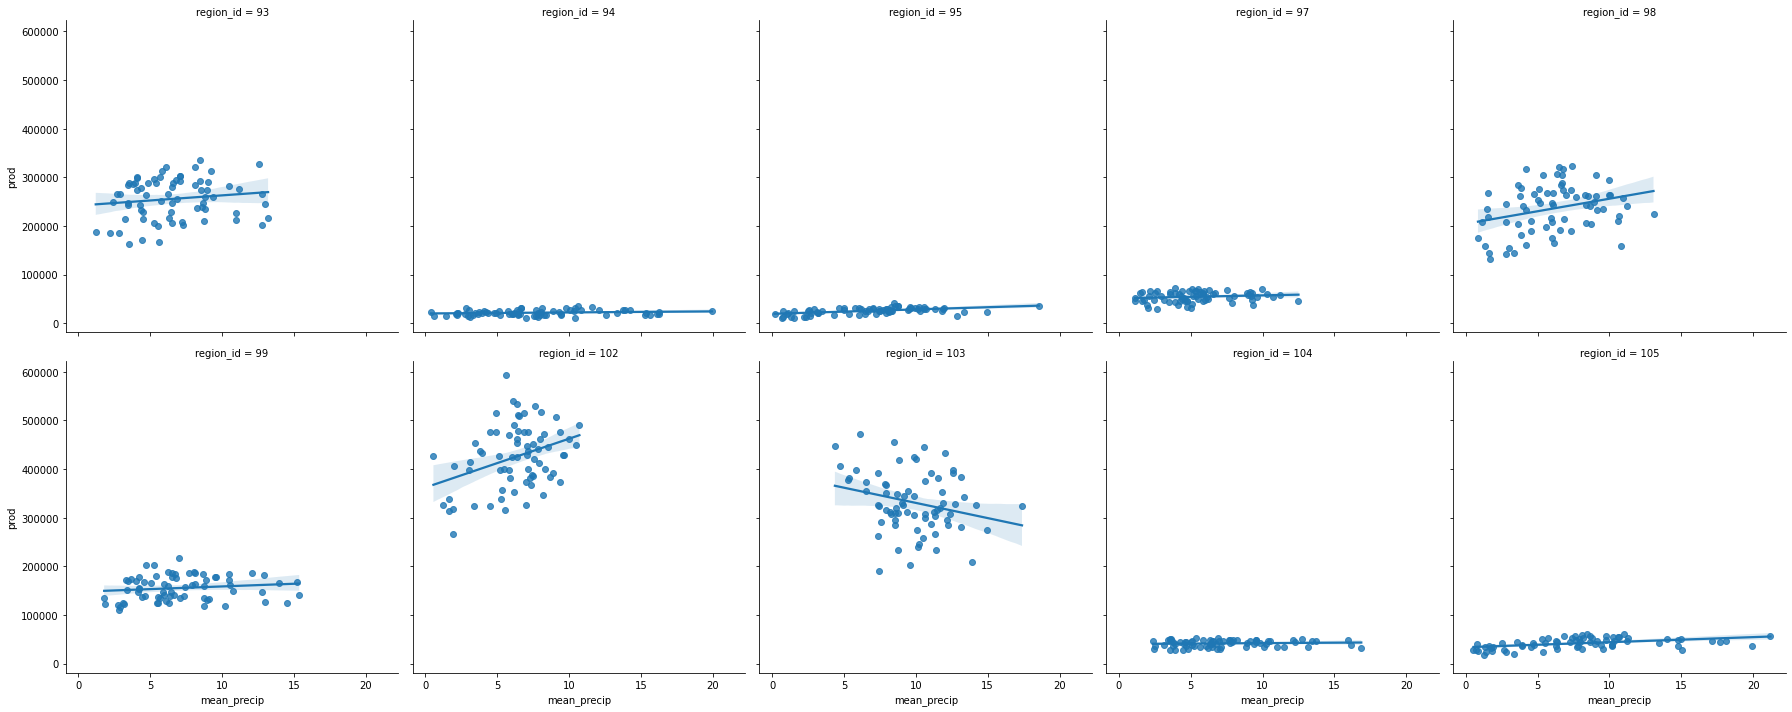

In [ ]:
_ = sns.lmplot(x='mean_precip', y='prod', col='region_id', col_wrap=5, data=df)
plt.show()

### 2.2 Mean Temperature vs Production

Temperatures are also positive correlatd with prodution.

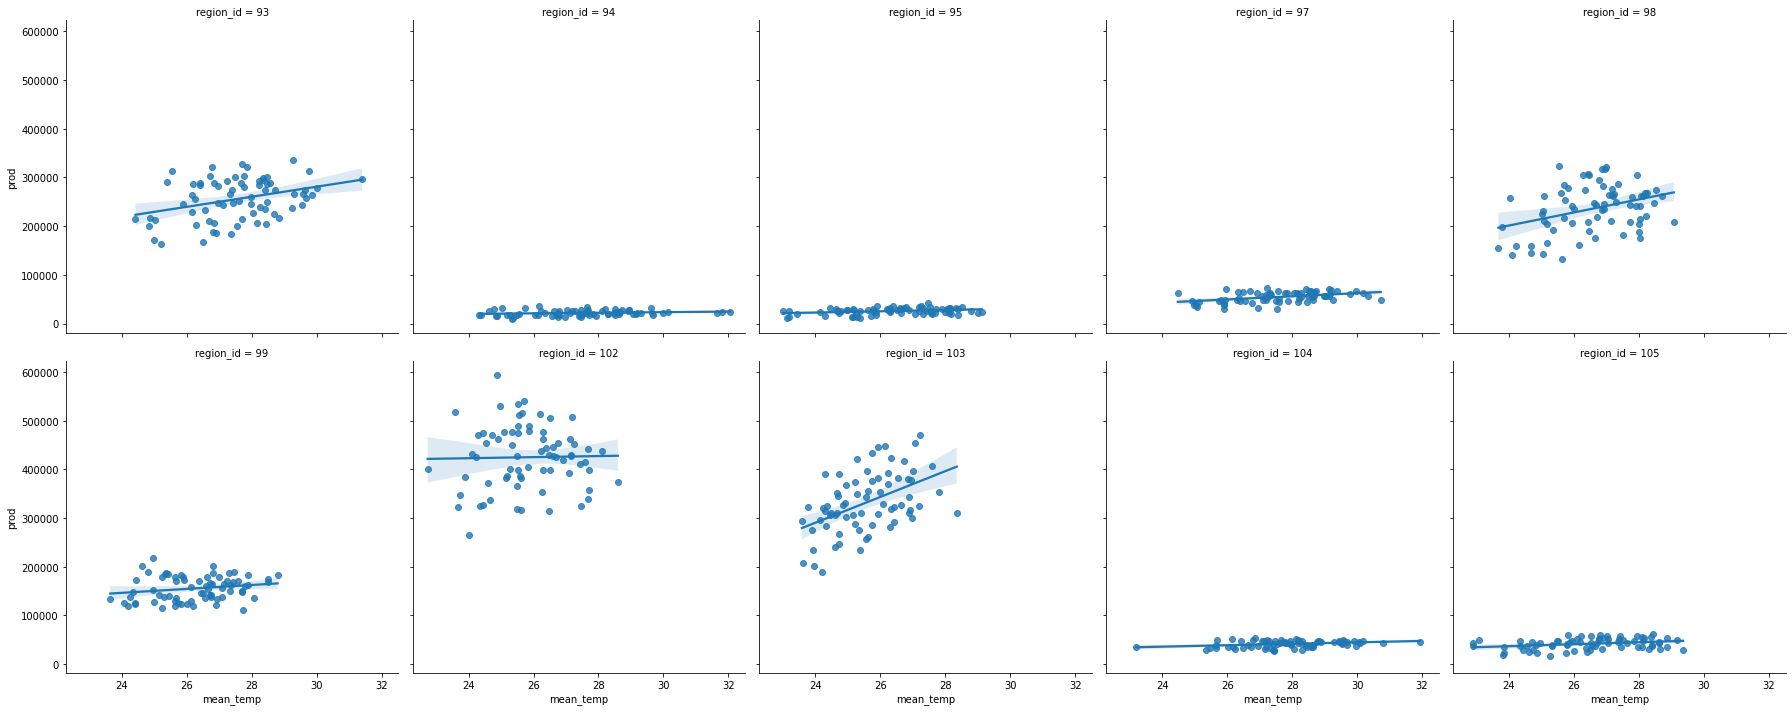

In [ ]:
_ = sns.lmplot(x='mean_temp', y='prod', col='region_id', col_wrap=5, data=df)
plt.show()

### 2.3 Mean Soil Moisture vs Production

The soil moisture is a bit different from other features. The correlations between `mean_smos` and `prod` are negative in region 97, 98, 102, and 103, while others remain positive.

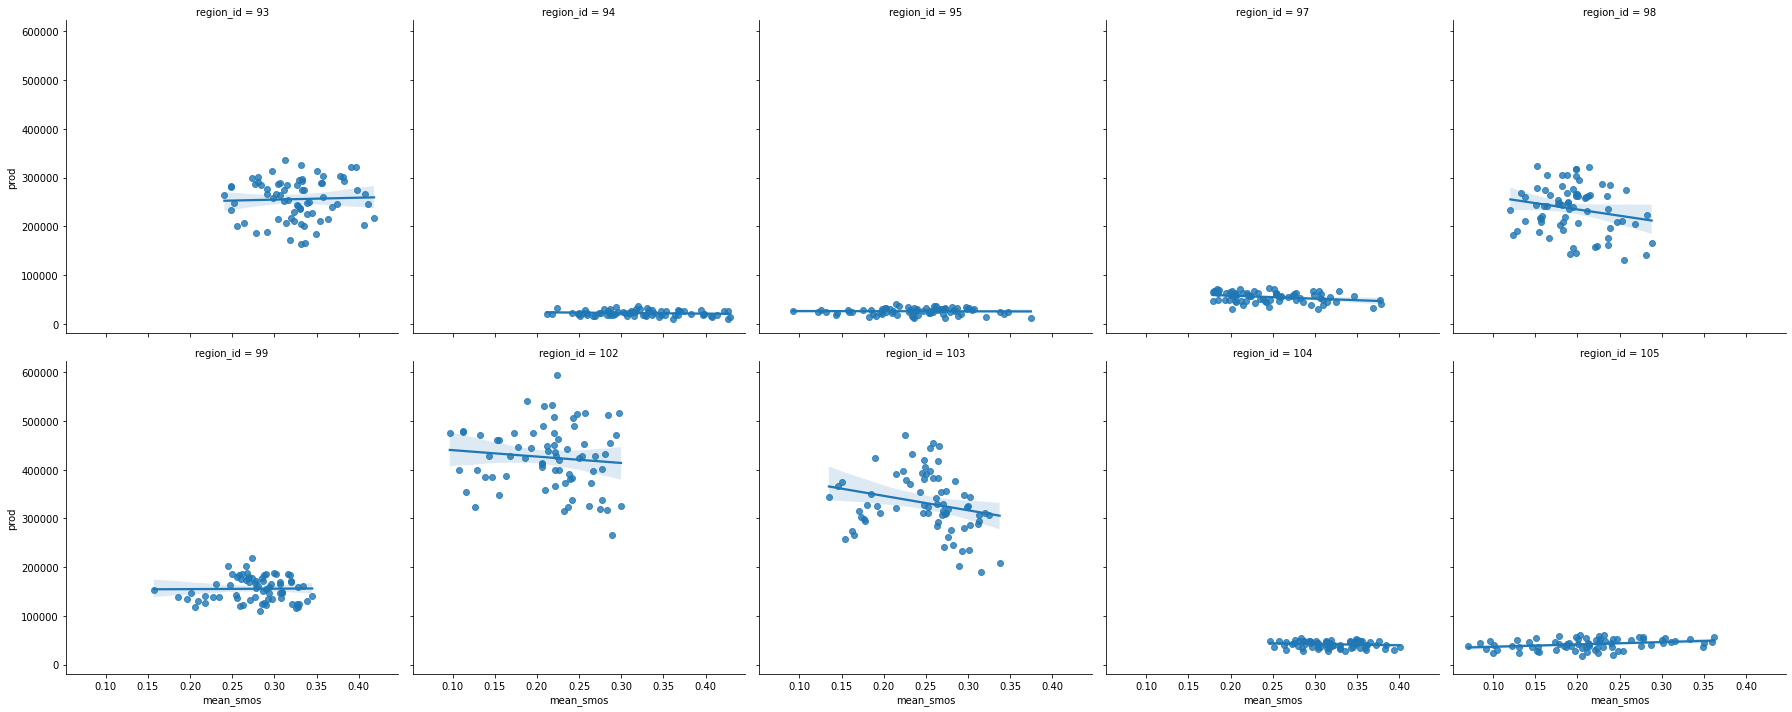

In [ ]:
_ = sns.lmplot(x='mean_smos', y='prod', col='region_id', col_wrap=5, data=df)
plt.show()

### 2.4 Monthly NDVI vs Production

Here, we can see that there is a potential outlier in region 93. Generally, the correlation betwwen `ndvi` and `prod` is mostly positvie.

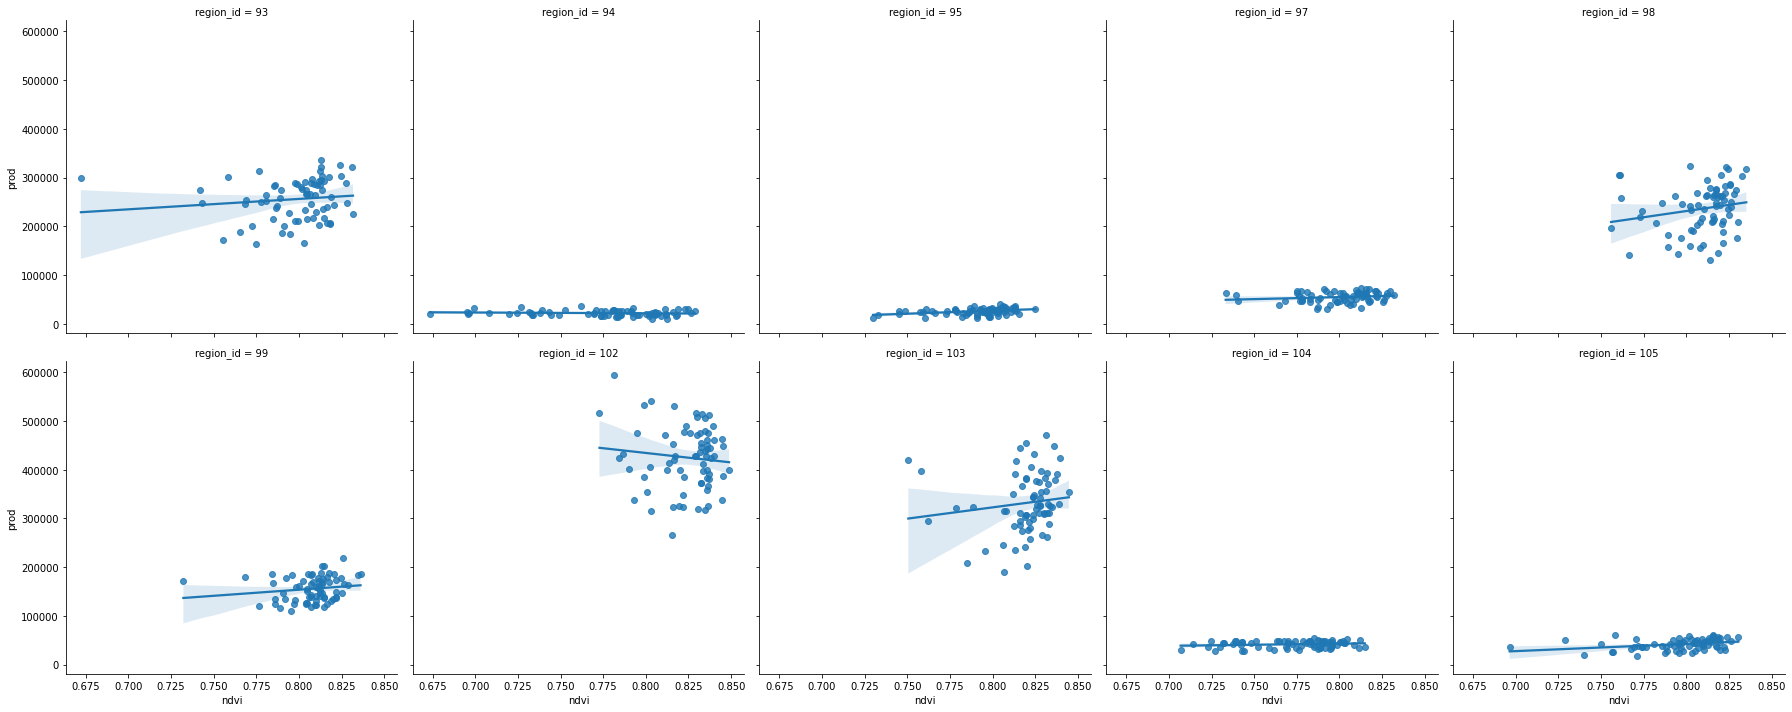

In [ ]:
_ = sns.lmplot(x='ndvi', y='prod', col='region_id', col_wrap=5, data=df)
plt.show()

### 2.5 Correlation Between Features by Region

To better understand the correlation between predictors and target variable, I would like to plot the correlation between features according to `region_id`.  

For **region 93**, `min_temp`, `mean_temp`, `median_temp`, `median_precip`, `max_temp` have relative high correlation with `prod`, indicating that temperature is an important factor to production quantity. While `max_precip` is negatively correlated with `prod`, which makes sense that over precipitation is harmful to the growth of crops.  

We can see another region 95 to understand the correlations between features. In contrast to region 93, `median_precip`, `mean_precip`, `max_precip`, `min_precip`, `ndvi`, `mean_temp`, `median_temp`, and `min_temp` become the major influences of `prod`. Regarding this difference, we would need to conclude the `region_id` as a predictor as different regions have different temperatures, precipitations, soil moistures, and NDVI.

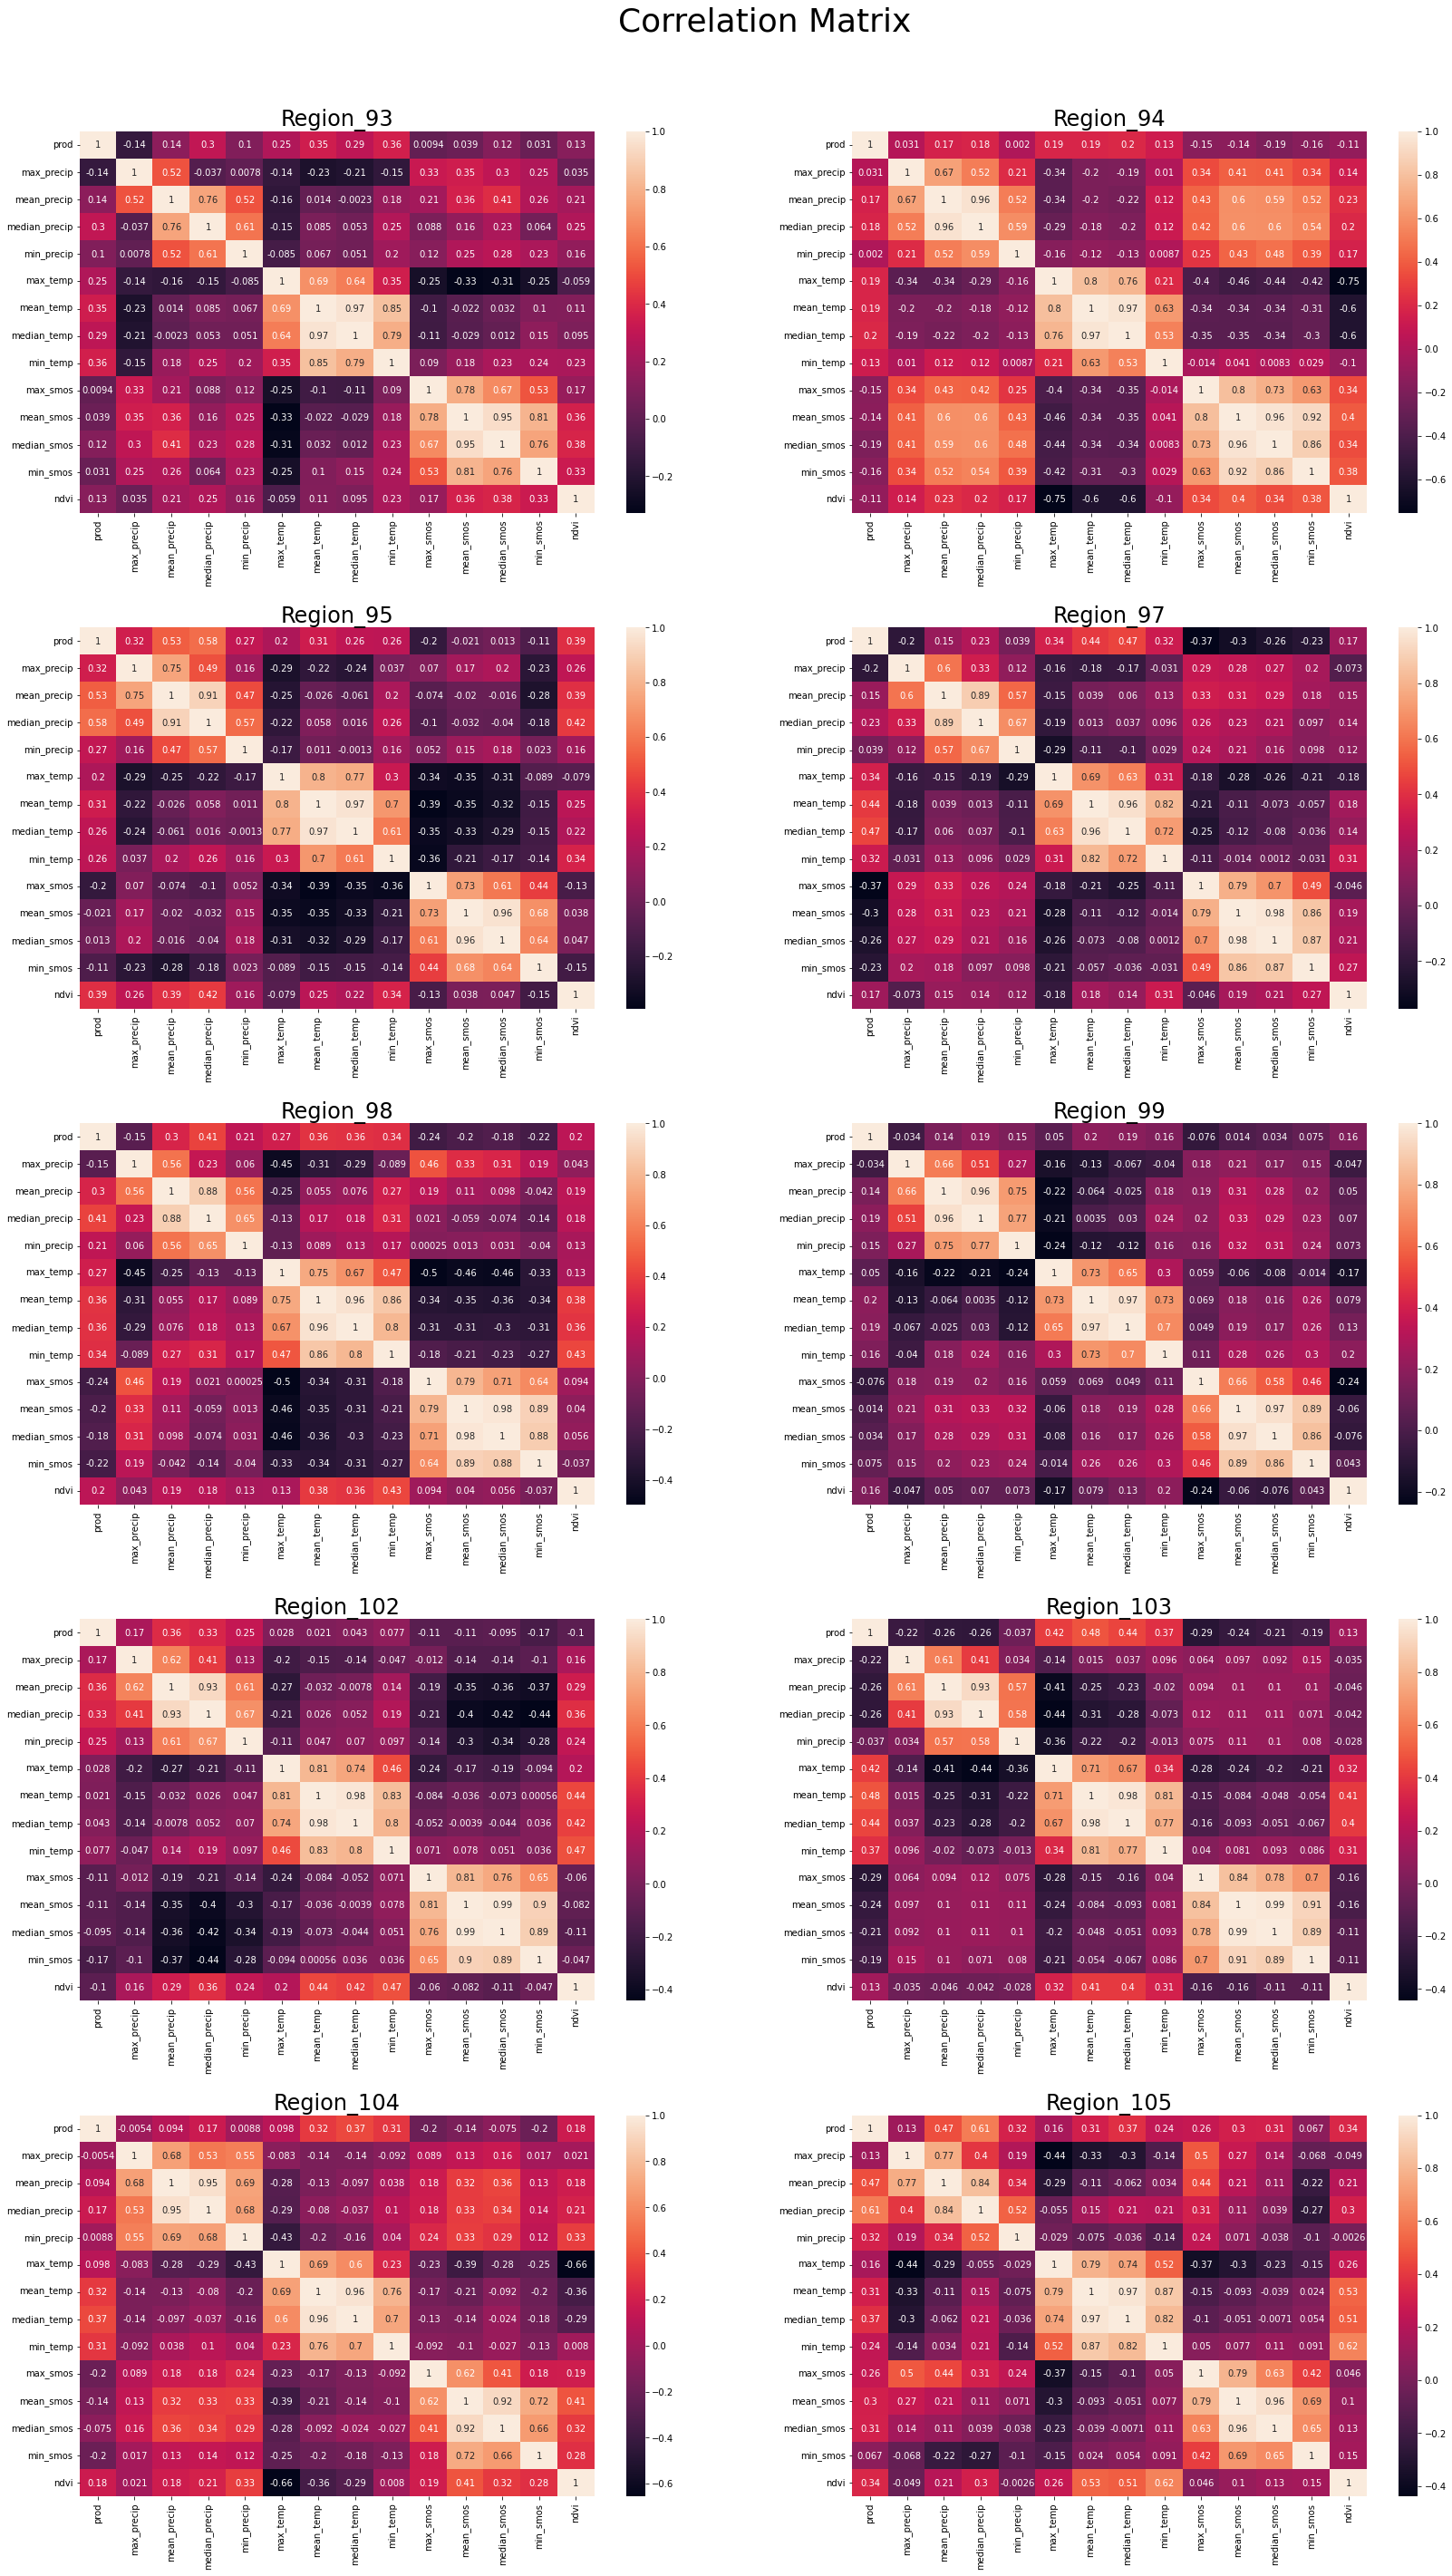

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(28, 48))
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Correlation Matrix", fontsize=36, y=0.92)
regions = prod['region_id'].unique().tolist()

# loop through tickers and axes
for region, ax in zip(regions, axs.ravel()):
  # filter df for region and plot on specified axes
  data = df[df['region_id'] == region].set_index('end_date').drop(['region_id', 'season', 'harvest'], axis=1)
  corr = data.corr()
  sns.heatmap(corr, annot=True, ax=ax)
  # chart formatting
  ax.set_title('Region_{}'.format(region), fontsize=24)

plt.show()

## 3 Modeling

### 3.1 Pre-work

Before get into data modeling, we need to dummy the data so that categorical factors are presented as numbers.

In [ ]:
# create a dummy dataframe
df_dummy = pd.get_dummies(df, drop_first=True)
df_dummy.columns.tolist()

['end_date',
 'prod',
 'max_precip',
 'mean_precip',
 'median_precip',
 'min_precip',
 'max_temp',
 'mean_temp',
 'median_temp',
 'min_temp',
 'max_smos',
 'mean_smos',
 'median_smos',
 'min_smos',
 'ndvi',
 'region_id_94',
 'region_id_95',
 'region_id_97',
 'region_id_98',
 'region_id_99',
 'region_id_102',
 'region_id_103',
 'region_id_104',
 'region_id_105',
 'season_2',
 'season_3',
 'season_4',
 'harvest_harvested',
 'harvest_normal']

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
X = df_dummy.drop(['end_date', 'prod'], axis=1)
y = df_dummy['prod'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape)
print(y.shape)

(720, 27)
(720, 1)


In [ ]:
def model_perf(alg_name, algo, eval=y_test, X_train=X_train, y_train=y_train):
  algo = algo.fit(X_train, y_train)
  y_pred = algo.predict(X_test)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print('{} Performance:'.format(alg_name))
  print('MAPE: %.4f' % mape)
  print('R2:   %.4f' % r2)
  return algo, y_pred, mape, r2

### 3.2 Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

First, let's try using **Linear Regression** to predict the production quantity. The performance of Linear Regression is not so good with MAPE of **26.60%**, which is too high. While we got R2 with **0.9455**, meaning our predictors explained most of the target variable.

In [ ]:
reg = LinearRegression()
reg, reg_pred, reg_mape, reg_r2 = model_perf('Linear Regression', algo=reg)

Linear Regression Performance:
MAPE: 0.2660
R2:   0.9455


In [ ]:
print(pd.DataFrame(dict({'features':reg.feature_names_in_.tolist(), 
                         'coef':reg.coef_[0]})))

             features           coef
0          max_precip     -73.714886
1         mean_precip    1179.937416
2       median_precip   -1467.262570
3          min_precip    1803.197290
4            max_temp    3658.180917
5           mean_temp    2174.865059
6         median_temp     153.379539
7            min_temp   -1610.170644
8            max_smos    9707.993716
9           mean_smos  -90702.425427
10        median_smos   79641.812337
11           min_smos   -6748.508321
12               ndvi  -91836.049247
13       region_id_94 -240396.331709
14       region_id_95 -227724.223248
15       region_id_97 -198509.292048
16       region_id_98  -16485.639487
17       region_id_99  -95062.463663
18      region_id_102  182614.350696
19      region_id_103   84545.140927
20      region_id_104 -218913.285739
21      region_id_105 -211893.766074
22           season_2    -826.694707
23           season_3   18834.439636
24           season_4   25442.730983
25  harvest_harvested   18834.439636
2

### 3.3 Ridge

We can also try using a Rdige model to see whether we can do better before scale data and punish overfitting. With alpha of 20, we can see the MAPE improved to **24.11%**, but we get a lower R2 with **0.94**.

In [ ]:
steps = [('scaler', StandardScaler()),
         ('reg', Ridge(alpha=20))]
pipeline = Pipeline(steps)

ridge, ridge_pred, ridge_mape, ridge_r2 = model_perf('Ridge', pipeline)

Ridge Performance:
MAPE: 0.2411
R2:   0.9397


### 3.4 Regression Tree

Since we have categorical features, it would be more suitable to use tree models to predict the result. Let's first use a **Regression Tree**. As shown below, we have a better MAPE with **18.96** and a R2 with **0.9367**, which proves our assumption that tree models can perform better.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [ ]:
tree = DecisionTreeRegressor(criterion='absolute_error', random_state=42)
tree, reg_tree_pred, reg_tree_mape, reg_tree_r2 = model_perf('Regression Tree', tree)

Regression Tree Performance:
MAPE: 0.1896
R2:   0.9367


In [ ]:
tree_perf = pd.DataFrame(dict({'features':tree.feature_names_in_, 
                              'importances':tree.feature_importances_}))
tree_perf.sort_values('importances', ascending=False, inplace=True, ignore_index=True)

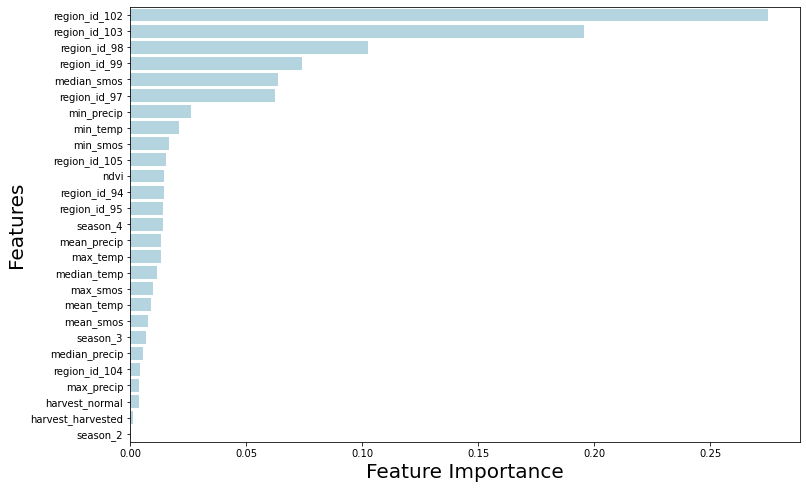

In [ ]:
plt.figure(figsize=(12, 8))
_ = sns.barplot(x='importances', y='features', color='lightblue', data=tree_perf)
_ = plt.xlabel('Feature Importance', fontsize=20)
_ = plt.ylabel('Features', fontsize=20)
plt.show()

### 3.5 Tuned Regression Tree

Since we are just using the default tree, now I would like to use *Random Search* to find the best hyperparameters. After tuning the tree, we can see the MAPE improved about 1% and a slightly increase in R2.

In [ ]:
parameters={"max_depth" : [3,5,7,9,11],
            "min_samples_leaf":[2,3,4,5,6],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[None,40,50,60,70,80]}

In [ ]:
tuned_tree = RandomizedSearchCV(tree, 
                                param_distributions = parameters,
                                scoring='neg_mean_absolute_percentage_error', 
                                cv=5, verbose=0, n_iter=200)

In [ ]:
tuned_tree, tuned_reg_tree_pred, tuned_reg_tree_mape, tuned_reg_tree_r2 = model_perf('Tuned Regression Tree', tuned_tree)

Tuned Regression Tree Performance:
MAPE: 0.1809
R2:   0.9368


In [ ]:
print(tuned_tree.best_params_)

{'min_samples_leaf': 3, 'max_leaf_nodes': 80, 'max_features': 'auto', 'max_depth': 11}


### 3.6 Extra Trees Regressor

Next I would like to try **Extra Trees Regressor**. We first set `max_depth` to 11, and keep others as default values. We can see there is a huge improve on MAPE from 18.09% to **15.83%**. Also, the predictors explained over 95% of the target variable.  

Moreover, according to the feature importances plot, **region** becomes the most important feature when predicting the production quantity, followed by **soil moisture**, and **season**.

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
extra_tree_reg = ExtraTreesRegressor(criterion='absolute_error',
                                     n_estimators=1000,
                                     max_depth=11,
                                     random_state=42)
etr, etr_pred, etr_mape, etr_r2 = model_perf('Extra Trees Regressor', extra_tree_reg, y_train=y_train.ravel())

Extra Trees Regressor Performance:
MAPE: 0.1583
R2:   0.9574


In [ ]:
etr_perf = pd.DataFrame(dict({'features':extra_tree_reg.feature_names_in_, 
                              'importances':extra_tree_reg.feature_importances_}))
etr_perf.sort_values('importances', ascending=False, inplace=True, ignore_index=True)

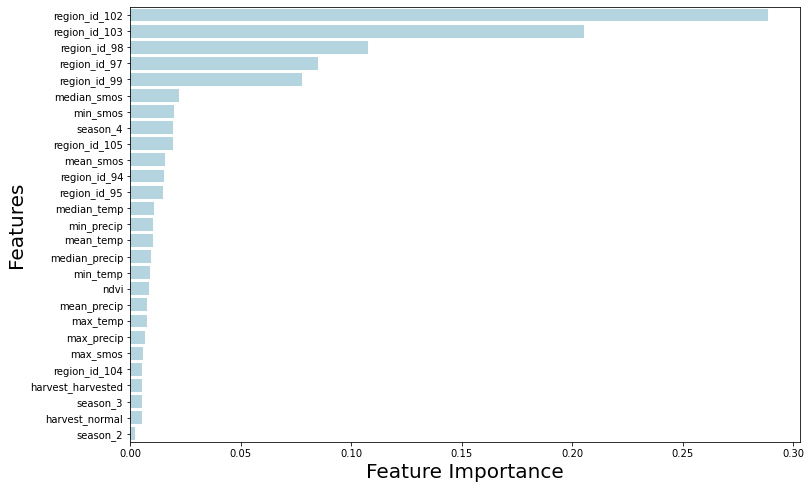

In [ ]:
plt.figure(figsize=(12, 8))
_ = sns.barplot(x='importances', y='features', color='lightblue', data=etr_perf)
_ = plt.xlabel('Feature Importance', fontsize=20)
_ = plt.ylabel('Features', fontsize=20)
plt.show()

### 3.7 Tuned Extra Tree Regressor

Also, tuning the model is necessary. First, I would like to utilize Random Search to find a specific combinations of hyperpatameters. We can that the performance of MAPE inceased to **14.95%** while R2 remains unchanged.

In [ ]:
params = {'max_depth': [11, 13, 15, 17],
          'min_samples_leaf': [1, 2, 3],
          'min_samples_split': [3, 4, 5, 6],
          'min_weight_fraction_leaf': [0, 0.1, 0.2],
          'min_impurity_decrease': [0, 0.01, 0.1]}
tuned_etr = RandomizedSearchCV(extra_tree_reg,
                               param_distributions=params,
                               scoring='neg_mean_absolute_percentage_error',
                               cv=5, verbose=0)

In [ ]:
tetr, tetr_pred, tetr_mape, tetr_r2 = model_perf('Tuned Extra Trees Regressor', tuned_etr, y_train=y_train.ravel())

Tuned Extra Trees Regressor Performance:
MAPE: 0.1495
R2:   0.9577


In [ ]:
print(tetr.best_params_)

{'min_weight_fraction_leaf': 0, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_depth': 17}


### 3.8 Random Forest

The last model I would like to try is **Random Forest**. While the performance of default random forest is even worse than linear regression with MAPE of **27.06** and R2 of **0.9350**.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=1000,
                           max_depth=11,
                           min_samples_leaf=5,
                           random_state=42)

rd, rf_pred, rf_mape, rf_r2 = model_perf('Random Forest Regressor', rf, y_train=y_train.ravel())

Random Forest Regressor Performance:
MAPE: 0.2706
R2:   0.9350


### 3.9 Tuned Random Forest

In [ ]:
parameters={"max_depth" : [1,3,5,7,9,11,12],
            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

In [ ]:
tuned_rf = RandomizedSearchCV(rf,
                              param_distributions=parameters,
                              scoring='neg_mean_absolute_percentage_error',
                              cv=5, verbose=0)

tuned_rd, tuned_rf_pred, tuned_rf_mape, tuned_rf_r2 = model_perf('Tuned Random Forest Regressor', tuned_rf, y_train=y_train.ravel())

Tuned Random Forest Regressor Performance:
MAPE: 1.1403
R2:   0.5973


In [ ]:
print(tuned_rf.best_params_)

{'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_depth': 12}


## 4 Model Performances

### 4.1 Model Comparison

To sum up, the best model is **Tuned Extra Trees Regressor** with MAPE of **14.95** and R2 of **0.96**. Hence, we would use it to predict our production quantity.

In [ ]:
results = pd.DataFrame({'model': ['Linear Regression', 'Ridge', 'Regression Tree', 'Tuned Regression Tree', 'Extra Trees Regressor', 'Tuned ETR', 'Random Forest', 'Tuned Random Forest'],
                        'MAPE': [reg_mape, ridge_mape, reg_tree_mape, tuned_reg_tree_mape, etr_mape, tetr_mape, rf_mape, tuned_rf_mape],
                        'R2': [reg_r2, ridge_r2, reg_tree_r2, tuned_reg_tree_r2, etr_r2, tetr_r2, rf_r2, tuned_rf_r2]})
results.sort_values('MAPE', ignore_index=True, inplace=True)
results

,model,MAPE,R2
0,Tuned ETR,0.149527,0.957673
1,Extra Trees Regressor,0.158313,0.957430
2,Tuned Regression Tree,0.180926,0.936849
3,Regression Tree,0.189631,0.936747
4,Ridge,0.241134,0.939726
5,Linear Regression,0.265999,0.945470
6,Random Forest,0.270611,0.935003
7,Tuned Random Forest,1.140261,0.597344


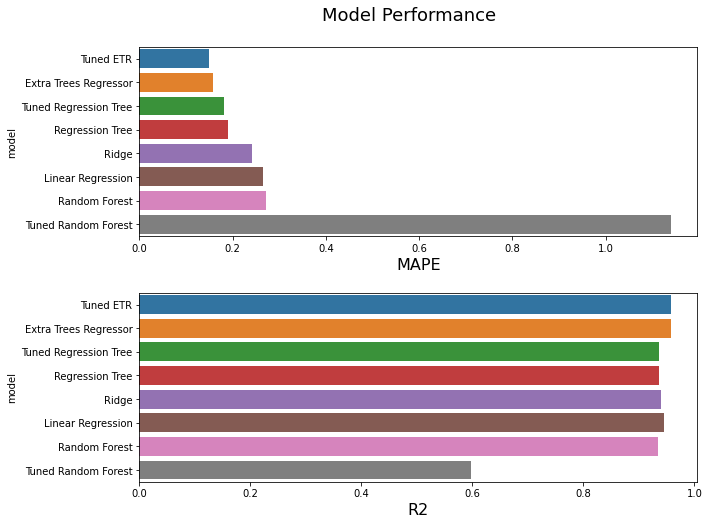

In [ ]:
fig, ax = plt.subplots(2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Model Performance", fontsize=18, y=0.95)
sns.barplot(y='model', x='MAPE', data=results, ax=ax[0])
sns.barplot(y='model', x='R2', data=results, ax=ax[1])
ax[0].set_xlabel('MAPE', fontsize=16)
ax[1].set_xlabel('R2', fontsize=16)
plt.show()

### 4.2 Prediction

Since we need to extract the predictors from previous tables, we need to transform the *predicted_production_qty.csv* file to the same format and merge them all. Also, we have to dummy the data to fit into the model.

In [ ]:
final_prediction = pd.read_csv('/content/drive/MyDrive/gro/predicted_production_qty.csv', parse_dates=['end_date'])

In [ ]:
# make a copy of final_prediction
prediction = final_prediction.drop('start_date', axis=1).copy()
prediction['end_date'] = prediction['end_date'].dt.date.astype('datetime64')
prediction = prediction.astype({'region_id':'category'})

In [ ]:
# combine all features with predicted dataframe
prediction = prediction.merge(precip, on=['end_date', 'region_id'])\
                       .merge(temp, on=['end_date', 'region_id'])\
                       .merge(smos, on=['end_date', 'region_id'])\
                       .merge(ndvi_long, on=['end_date', 'region_id'])
# add season
prediction['season'] = prediction['end_date'].dt.month % 12 // 3 + 1
# add a seasonal feature
prediction['harvest'] = np.empty(len(prediction))
prediction.loc[(prediction['end_date'].dt.month >= 6) & (prediction['end_date'].dt.month <= 8), 'harvest'] = 'harvested'
prediction.loc[prediction['end_date'].dt.month <= 3, 'harvest'] = 'growing'
prediction.loc[(prediction['harvest'] != 'harvested' ) & (prediction['harvest'] != 'growing'), 'harvest'] = 'normal'
prediction = prediction.astype({'harvest': 'category', 'season':'category'})

In [ ]:
print(prediction.dtypes, '\n')
prediction.head()

end_date         datetime64[ns]
prod                    float64
region_id              category
max_precip              float64
mean_precip             float64
median_precip           float64
min_precip              float64
max_temp                float64
mean_temp               float64
median_temp             float64
min_temp                float64
max_smos                float64
mean_smos               float64
median_smos             float64
min_smos                float64
ndvi                    float64
season                 category
harvest                category
dtype: object 



,end_date,prod,region_id,max_precip,mean_precip,median_precip,min_precip,max_temp,mean_temp,median_temp,min_temp,max_smos,mean_smos,median_smos,min_smos,ndvi,season,harvest
0,2021-01-31,NaN,93,148.306510,15.395451,2.299993,0.029003,26.138953,25.093076,24.764539,24.156424,0.551477,0.430121,0.421060,0.312419,0.803077,1,growing
1,2021-02-28,NaN,93,6.121829,0.478108,0.055563,0.000000,31.882281,26.897011,26.677204,23.387195,0.489135,0.376494,0.354787,0.279426,0.775201,1,growing
2,2021-03-31,NaN,93,51.574732,6.838074,4.082503,0.008030,29.946451,28.251589,28.865965,25.807317,0.368453,0.321724,0.342398,0.248087,0.775740,2,growing
3,2021-04-30,NaN,93,26.948868,8.185650,5.306927,0.311938,30.074846,27.924892,27.503567,25.628036,0.451836,0.372365,0.375338,0.279504,0.811771,2,normal
4,2021-05-31,NaN,93,50.084512,8.845651,6.499226,0.195479,29.819850,26.930918,27.277122,23.400677,0.459129,0.350557,0.329901,0.230932,0.822010,2,normal


In [ ]:
# dummy the predicted dataframe
prediction = pd.get_dummies(prediction, drop_first=True)
prediction.columns.tolist()

['end_date',
 'prod',
 'max_precip',
 'mean_precip',
 'median_precip',
 'min_precip',
 'max_temp',
 'mean_temp',
 'median_temp',
 'min_temp',
 'max_smos',
 'mean_smos',
 'median_smos',
 'min_smos',
 'ndvi',
 'region_id_94',
 'region_id_95',
 'region_id_97',
 'region_id_98',
 'region_id_99',
 'region_id_102',
 'region_id_103',
 'region_id_104',
 'region_id_105',
 'season_2',
 'season_3',
 'season_4',
 'harvest_harvested',
 'harvest_normal']

In [ ]:
# drop end_date and prod
prediction = prediction.drop(['end_date', 'prod'], axis=1)
print(prediction.shape)

(120, 27)


In [ ]:
# predict using Tuned Extra Trees Regressor
prediction['prod'] = tetr.predict(prediction)

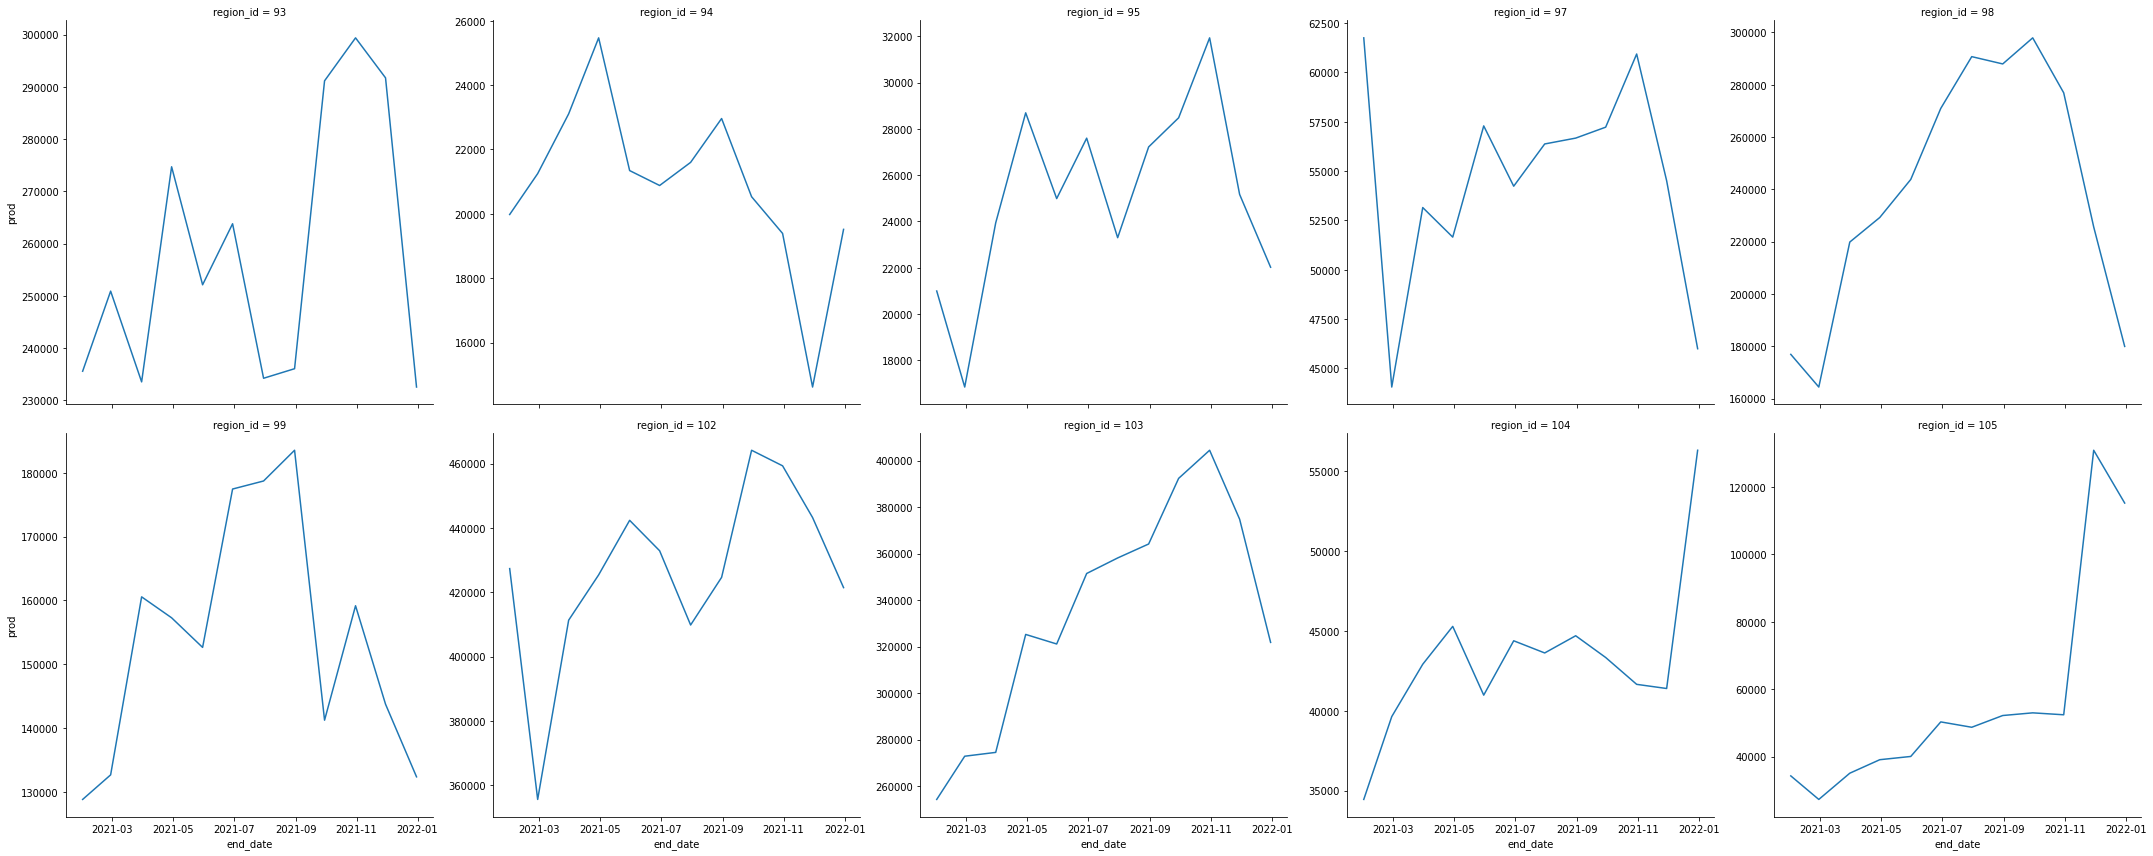

In [ ]:
# visualize the final prediction
g = sns.FacetGrid(final_prediction, col='region_id', col_wrap=5, sharey=False, height=6)
g.map(sns.lineplot, 'end_date', 'prod')
plt.show()

In [ ]:
# import the result back to the final file
final_prediction['prod'] = prediction['prod']

In [ ]:
# final check
print(final_prediction.isnull().sum(), '\n')
final_prediction

start_date    0
end_date      0
prod          0
region_id     0
dtype: int64 



,start_date,end_date,prod,region_id
0,2021-01-01T00:00:00.000Z,2021-01-31 00:00:00+00:00,235562.7400,93
1,2021-02-01T00:00:00.000Z,2021-02-28 00:00:00+00:00,250898.6360,93
2,2021-03-01T00:00:00.000Z,2021-03-31 00:00:00+00:00,233523.9345,93
3,2021-04-01T00:00:00.000Z,2021-04-30 00:00:00+00:00,274708.1730,93
4,2021-05-01T00:00:00.000Z,2021-05-31 00:00:00+00:00,252113.3450,93
...,...,...,...,...
115,2021-08-01T00:00:00.000Z,2021-08-31 00:00:00+00:00,52205.0655,105
116,2021-09-01T00:00:00.000Z,2021-09-30 00:00:00+00:00,52997.8535,105
117,2021-10-01T00:00:00.000Z,2021-10-31 00:00:00+00:00,52424.8150,105
118,2021-11-01T00:00:00.000Z,2021-11-30 00:00:00+00:00,130893.0200,105


In [ ]:
# save to file
final_prediction.to_csv('/content/drive/MyDrive/gro/yz4107@columbia.edu.csv', index=False)